# Project 1 - Collaborative Filtering

### ETH Computational Intelligence Lab 2021 - Project 1 

Disclaimer: Most methods mentioned here are briefly presented and not optimized. A solid baseline comparison may explore ways to optimize these. 

The problem of collaborative filtering concerns providing users with personalized product recommendations. The growth of e-commerce and social media platforms has established the need for recommender systems capable of providing personalized product recommendations. Here we resolve to past user behavior and exploit data dependencies to predict preferences for specific user-item interactions. 

This problem attracted great interest by the introduction of the [Netflix Prize](https://www.netflixprize.com/) that aimed to improve recommendations of Netflix's own algorithm. Given a list of users-items interactions, the task is to predict a series of ratings for another list of future interactions.

In our setting, we are dealing with a smaller dataset. 

We are given a set of $N = 1,176,952$ integer movie ratings, ranging from $1$ to $5$, that are assigned by $m=10,000$ users to $n=1,000$ movies. A rating $r_{ui}$ indicates the preference by user $u$ of item $i$. Let $\mathcal{\Omega} = \{(u,i) : r_{ui} \text{ is known} \}$ be the set of user and movie indices for which the ratings are known. 

In [10]:
#@title Basic Imports

import pandas as pd
import numpy as np
import math

To download the data make sure you have joined the kaggle competition. Then create an api key through kaggle.

In [11]:
#@title Download data
import json

!pip install kaggle

!mkdir ~/.kaggle

kaggle_username = "" #@param {type:"string"}
kaggle_api_key = "" #@param {type:"string"}

assert len(kaggle_username) > 0 and len(kaggle_api_key) > 0

api_token = {"username": kaggle_username,"key": kaggle_api_key}

with open('kaggle.json', 'w') as file:
    json.dump(api_token, file)

!mv kaggle.json ~/.kaggle/kaggle.json

!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c cil-collaborative-filtering-2021

!rm *.csv
!unzip cil-collaborative-filtering-2021.zip
# !unzip data_train.csv.zip

mkdir: cannot create directory ‘/home/fatjon/.kaggle’: File exists
cil-collaborative-filtering-2021.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  cil-collaborative-filtering-2021.zip
  inflating: data_train.csv          
  inflating: sampleSubmission.csv    


In [12]:
number_of_users, number_of_movies = (10000, 1000)

data_pd = pd.read_csv('data_train.csv')
print(data_pd.head(5))
print()
print('Shape', data_pd.shape)

       Id  Prediction
0  r44_c1           4
1  r61_c1           3
2  r67_c1           4
3  r72_c1           3
4  r86_c1           5

Shape (1176952, 2)


The provided data $\mathcal{\Omega}$ are split into two disjoint subsets, namely $\mathcal{\Omega}_{\text{train}}$ and $\mathcal{\Omega}_{\text{test}}$. The former consists of $90\%$ of the data and is used for training the individual models whereas the latter consists of the remaining $10\%$ of the data and is used for learning optimal blending weights. Depending on your method, you may choose to retrain on the whole dataset for the final solution.

In [13]:
from sklearn.model_selection import train_test_split
# Split the dataset into train and test

train_size = 0.9

train_pd, test_pd = train_test_split(data_pd, train_size=train_size, random_state=42)

Preprocess data by creating a $m \times n$ matrix

$$A_{ui} = \begin{cases} 
      r_{ui} & \text{ if } (u,i) \in \mathcal{\Omega}_{\text{train}} \\
      0 & \text{ else }
\end{cases}.$$

In [14]:
def extract_users_items_predictions(data_pd):
    users, movies = \
        [np.squeeze(arr) for arr in np.split(data_pd.Id.str.extract('r(\d+)_c(\d+)').values.astype(int) - 1, 2, axis=-1)]
    predictions = data_pd.Prediction.values
    return users, movies, predictions

train_users, train_movies, train_predictions = extract_users_items_predictions(train_pd)

# also create full matrix of observed values
data = np.full((number_of_users, number_of_movies), np.mean(train_pd.Prediction.values))
mask = np.zeros((number_of_users, number_of_movies)) # 0 -> unobserved value, 1->observed value

for user, movie, pred in zip(train_users, train_movies, train_predictions):
    data[user - 1][movie - 1] = pred
    mask[user - 1][movie - 1] = 1

To consider:
* Do unobserved values matter for the method we are using? If yes, is the above initialization the best?
* Does normalization of the data matter for the method we are using?
* If yes, should we do the same transformations for the test data?

Our task is to predict ratings according to specific users-movies combinations. We will quantify the quality of our predictions based on the root mean squared error (RMSE) function between the true and observed ratings. For a given set of observations $ \mathcal{\Omega}$, let
\begin{equation}
    \text{RMSE} = \sqrt{\frac{1}{|\mathcal{\Omega}|}\sum_{ (u,i) \in \mathcal{\Omega}} \big(r_{ui} - \hat{r}_{ui}\big)^2}
\end{equation}
where $\hat{r}_{ui}$ denotes the estimate of $r_{ui}$.

In [15]:
from sklearn.metrics import mean_squared_error

rmse = lambda x, y: math.sqrt(mean_squared_error(x, y))

test_users, test_movies, test_predictions = extract_users_items_predictions(test_pd)

# test our predictions with the true values
def get_score(predictions, target_values=test_predictions):
    return rmse(predictions, target_values)

def extract_prediction_from_full_matrix(reconstructed_matrix, users=test_users, movies=test_movies):
    # returns predictions for the users-movies combinations specified based on a full m \times n matrix
    assert(len(users) == len(movies)), "users-movies combinations specified should have equal length"
    predictions = np.zeros(len(test_users))

    for i, (user, movie) in enumerate(zip(users, movies)):
        predictions[i] = reconstructed_matrix[user][movie]

    return predictions

# Methods and Approaches

## Singular Value Decomposition (SVD)

Assuming that column entries are not random, we attempt to fill the missing entries by capturing some of the most significant components of the underlying data. Assume that a latent factor model associates each user $u$ with a set of user factors $ p_u \in \mathbb{R}^k$ and each item $i$ with a set of item factors $ q_i \in \mathbb{R}^k$. In the case of movies, some of these factors could correspond to movie genres such as comedy, drama, action etc. For each item $i$, the elements of $ q_i$ quantify the extent to which the item possesses these factors. Similarly, for each user $u$, the elements of $ p_u$ measure the level of interest that the user has to each of these factors. In this framework, user-item interactions are modeled by inner products in the latent space, leading to the following prediction rule 
\begin{equation}
\hat{r}_{ui} =  p_u^T q_i.
\end{equation}

Singular Value Decomposition (SVD) [1] is a widely used technique for matrix factorization. Any matrix $ M \in \mathbb{R}^{m \times n}$ can be decomposed into $A = U \Sigma V^T$, where $ U \in \mathbb{R}^{m\times m}$, $ \Sigma \in \mathbb{R}^{m \times n}$ and $ V \in \mathbb{R}^{n \times n}$. Matrices $ U$ and $ V$ are orthogonal, whereas $ \Sigma$ has $ rank(A)$ positive entries on the main diagonal sorted in decreasing order of value. 

We apply the SVD on the imputed user-item matrix to decompose it into $A =  U  \Sigma  V^T$. We may assume that a list of $k$ distinguishes users' interests and movies' characteristics. This motivates us to approximate $A$ by another matrix of low rank. The Eckart-Young theorem [2] states that the optimal (in terms of the Frobenius norm objective) rank $k$ approximation of the matrix $A$ is given by $A_k =  U_k  \Sigma_k  V^T_k$, where $ U_k \in \mathbb{R}^{m \times k}$, $ \Sigma_k \in \mathbb{R}^{k \times k}$ and $ V_k \in \mathbb{R}^{n \times k}$. $ U_k$ and $ V_k$ correspond to the first $k$ columns of $ U$ and $ V$ respectively and $ \Sigma_k$ to the $k \times k$ sub-matrix of $ \Sigma$ containing the $k$ largest singular values. 

----------------
[1] Klema, Virginia, and Alan Laub. "The singular value decomposition: Its computation and some applications." IEEE Transactions on automatic control 25.2 (1980): 164-176.

[2] Eckart, Carl, and Gale Young. "The approximation of one matrix by another of lower rank." Psychometrika 1.3 (1936): 211-218.

How many singular values should we keep? Try them all!
This is why we first use a train-validation split.

In [16]:
# choose how many singlular values to keep
k_singular_values = 2
number_of_singular_values = min(number_of_users, number_of_movies)

assert(k_singular_values <= number_of_singular_values), "choose correct number of singular values"

U, s, Vt = np.linalg.svd(data, full_matrices=False)

S = np.zeros((number_of_movies, number_of_movies))
S[:k_singular_values, :k_singular_values] = np.diag(s[:k_singular_values])

reconstructed_matrix = U.dot(S).dot(Vt)
    
predictions = extract_prediction_from_full_matrix(reconstructed_matrix)

print("RMSE using SVD is: {:.4f}".format(get_score(predictions)))

RMSE using SVD is: 1.1164


To consider:
* How can we improve SVD? As aforementioned initialization of unobserved values matters for SVD.
* Can we use SVD iteratively to better initialize unobserved values?
* Maybe start from a low-rank reconstruction and after you have ensured better initialization increase the reconstruction rank.
* Can we make adjustments to SVD? Other variations exist, see e.g. [1, 2], Singular Value Projection, Nuclear Norm Relaxation ...
 
--------------
[1] Cai, Jian-Feng, Emmanuel J. Candès, and Zuowei Shen. "A singular value thresholding algorithm for matrix completion." SIAM Journal on optimization 20.4 (2010): 1956-1982.
 
[2] Zarmehi, Nematollah, and Farokh Marvasti. "Adaptive singular value thresholding." 2017 International Conference on Sampling Theory and Applications (SampTA). IEEE, 2017.


## Alternating Least Squares (ALS)
 
SVD is very sensitive to initialization. Can we propose a method that defines a loss function only on the user-items interactions observed and not the whole matrix? Regularizing the weights also improves stability and ensures simpler solutions in accordance with [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor).
 
Can we propose a method that defines a loss function only on the user-items interactions observed? 

Our new objective is to minimize the following loss-function
\begin{equation}
\sum\limits_{(u,i) \in \mathcal{\Omega}_{\text{train}}}(r_{ui} - p_u^T q_i)^2 + \lambda\sum_{u=1}^m\| p_u\|^2 + \lambda\sum\limits_{i=1}^n \| q_i\|^2,
\end{equation}
where $\lambda$ denotes a tunable regularization parameter.
 
How can we optimize this objective? In general it is a non-convex problem. Optimize using stochastic gradient descent.
 
 
--------------
[1] Koren, Yehuda, Robert Bell, and Chris Volinsky. "Matrix factorization techniques for recommender systems." Computer 42.8 (2009): 30-37.
 

## Improved SVD
 
Can we also include user-specific or movie-specific biases?
 
Compare to the simple SVD assumption
\begin{equation}
\hat{r}_{ui} =  p_u^T q_i,
\end{equation}
a more reasonable premise is [1]
\begin{equation}
r_{ui} = p_u^T q_i + b_u + b_i,
\end{equation}
where $b_u, b_i \in \mathbb{R}$, allowing to model a significant portion of the observed variation that comes from effects associated with either the user or the items.
 
This allows us to model more complex interactions. Optimization is done similarly to (ALS).
 
------------
[1] Paterek, Arkadiusz. "Improving regularized singular value decomposition for collaborative filtering." Proceedings of KDD cup and workshop. Vol. 2007. 2007.
 


Exercise:
- Implement ALS and Improved SVD and test its performance on the test dataset. Especially for large datasets, optimization via [Stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) is chosen (more on this in later lectures). Derive the derivatives in terms of $p_u, q_i, b_u, b_i$ and choose a suitable learning rate (a specific value or decaying with time).

## Autoencoder
An autoencoder is a type of neural network that is used to learn efficient, low-dimensional data representations in an unsupervised manner [1]. It implements two transformations: first, the encoder $g_e : \mathbb{R}^d \rightarrow \mathbb{R}^k$ and secondly, the decoder $g_d : \mathbb{R}^k \rightarrow \mathbb{R}^d$, where $k < d$. The network is trained by minimizing the squared reconstruction loss between the input $ x$ and output $\hat{x} = g_d(g_e(x))$, thereafter learning an intermediate $k-$dimensional representation for $x$.

----------

[1] Hinton, Geoffrey E., and Ruslan R. Salakhutdinov. "Reducing the dimensionality of data with neural networks." science 313.5786 (2006): 504-507.


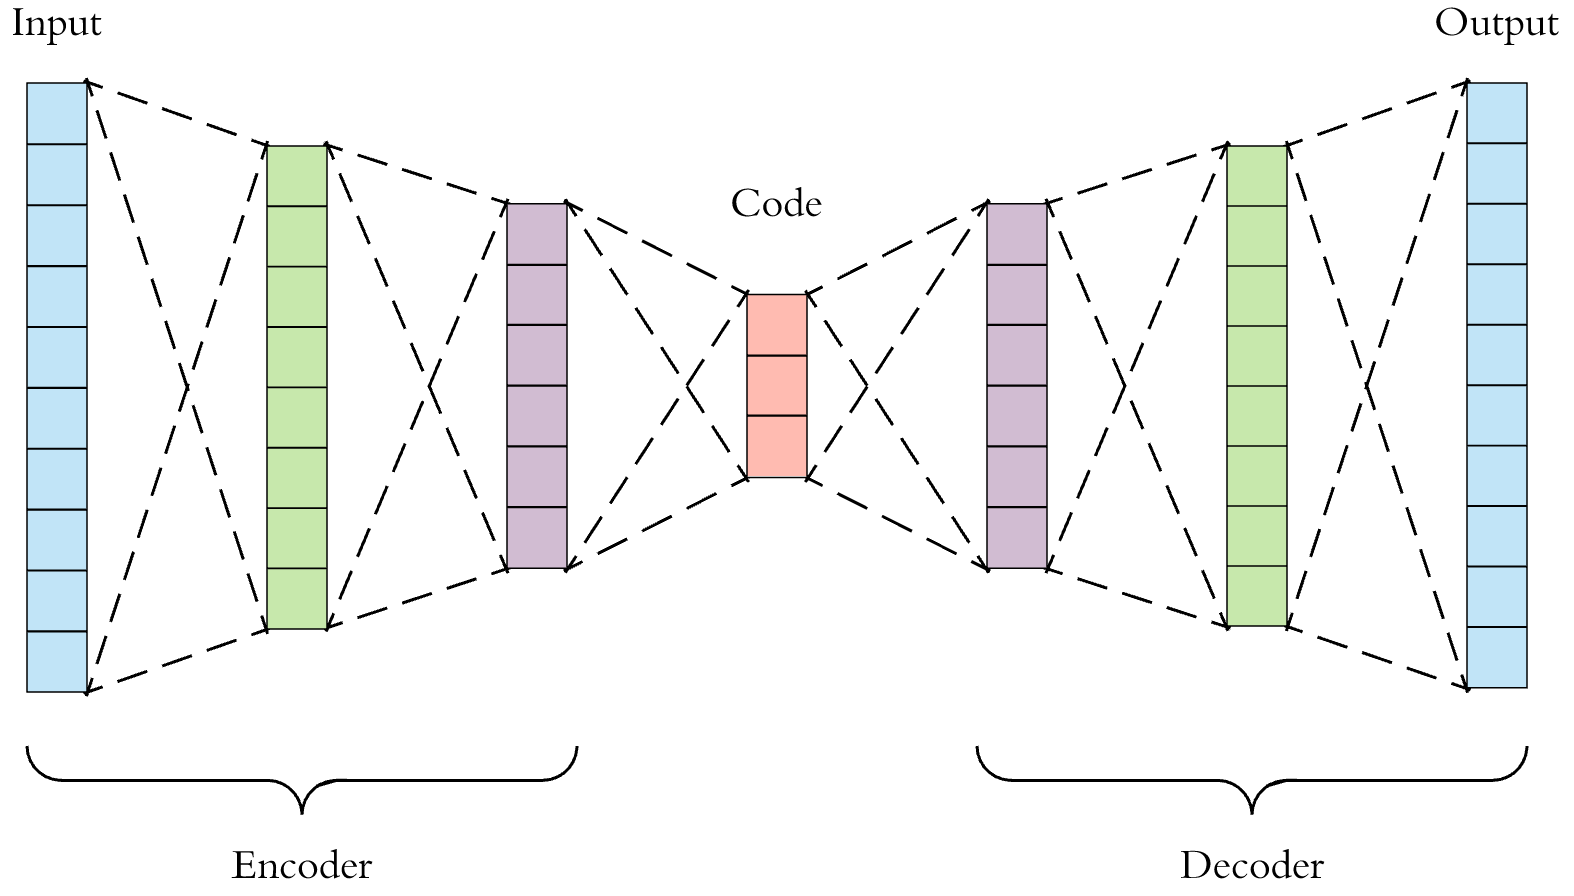

Similar to the SVD assumptions we may choose to use an autoencoder to learn the interactions. Deep autoencoders allow capruting of non-linear more complex interconnections. Autoencoders have proven to be very effective in the context of collaborative filtering [1, 2, 3]. Reconstruct for each user their 

------------
[1] Sedhain, Suvash, et al. "Autorec: Autoencoders meet collaborative filtering." Proceedings of the 24th international conference on World Wide Web. 2015.

[2] Strub, Florian, and Jeremie Mary. "Collaborative filtering with stacked denoising autoencoders and sparse inputs." NIPS workshop on machine learning for eCommerce. 2015.

[3] Kuchaiev, Oleksii, and Boris Ginsburg. "Training deep autoencoders for collaborative filtering." arXiv preprint arXiv:1708.01715 (2017).

In [17]:
#@title Use GPU in colab: Runtime->Change Runtime type
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Using device: cuda


In [18]:
class Encoder(nn.Module):
    def __init__(self, input_dimension, encoded_dimension=16):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(in_features=input_dimension, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=encoded_dimension),
            nn.ReLU()
        )
    
    def forward(self, data):
        return self.model(data)

class Decoder(nn.Module):
    def __init__(self, output_dimensions, encoded_dimension=16):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(in_features=encoded_dimension, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=output_dimensions),
            nn.ReLU() # How does the output look like? What about if you had first centered the data?!
        )
    
    def forward(self, encodings):
        return self.model(encodings)


class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, data):
        return self.decoder(self.encoder(data))

In [19]:
# Parameters
batch_size = 64
num_epochs = 1000
show_validation_score_every_epochs = 5
encoded_dimension = 16
learning_rate = 1e-3

In [20]:
# Model
autoencoder = AutoEncoder(
    encoder=Encoder(
        input_dimension=number_of_movies,
        encoded_dimension=encoded_dimension,
    ),
    decoder=Decoder(
        output_dimensions=number_of_movies,
        encoded_dimension=encoded_dimension,
    )
).to(device)

optimizer = optim.Adam(autoencoder.parameters(),
                       lr=learning_rate)

# Build Dataloaders
data_torch = torch.tensor(data, device=device).float()
mask_torch = torch.tensor(mask, device=device)

dataloader = DataLoader(
    TensorDataset(data_torch, mask_torch),
    batch_size=batch_size)

# L2 loss between original ratings and reconstructed ratings for the observed values
def loss_function(original, reconstructed, mask):
    return torch.mean(mask * (original - reconstructed) ** 2)

# reconstuct the whole array
def reconstruct_whole_matrix(autoencoder):
    data_reconstructed = np.zeros((number_of_users, number_of_movies))
    
    with torch.no_grad():
        for i in range(0, number_of_users, batch_size):
            upper_bound = min(i + batch_size, number_of_users)
            data_reconstructed[i:upper_bound] = autoencoder(data_torch[i:upper_bound]).detach().cpu().numpy()

    return data_reconstructed

In [21]:
# collect losses for qualitative inspection
autoencoder_logdir = './tensorboard/autoencoder'
writer = SummaryWriter(autoencoder_logdir)

step = 0
with tqdm(total=len(dataloader) * num_epochs) as pbar:
    for epoch in range(num_epochs):
        for data_batch, mask_batch in dataloader:
            optimizer.zero_grad()

            reconstructed_batch = autoencoder(data_batch)

            loss = loss_function(data_batch, reconstructed_batch, mask_batch)

            loss.backward()

            optimizer.step()

            writer.add_scalar('loss', loss, step)
            pbar.update(1)
            step += 1

        if epoch % show_validation_score_every_epochs == 0:
            reconstructed_matrix = reconstruct_whole_matrix(autoencoder)
            predictions = extract_prediction_from_full_matrix(reconstructed_matrix)
            reconstuction_rmse = get_score(predictions)
            pbar.set_description('At epoch {:3d} loss is {:.4f}'.format(epoch, reconstuction_rmse))

            writer.add_scalar('reconstuction_rmse', reconstuction_rmse, step)

  0%|          | 0/157000 [00:00<?, ?it/s]

In [22]:
# We can visualize the tensorboard logs.
%load_ext tensorboard
%tensorboard --logdir ./tensorboard

Launching TensorBoard...

What modifications can be made to make our autoencoder model much better?
* Are the layer's parameters optimal?
* Can we introduce regularization for the autoencoder as well?
* Can we add user biases, similar to improved SVD?
* Here we have encoded users, can we do the same with movies?
* Extensions to [autoencoders](https://en.wikipedia.org/wiki/Autoencoder) include variational autoencoders.
 

## Neural Collaborative Filtering [1]

Since artificial neural networks have good capabilities to approximate any function [2, 3] we adopt the Neural Collaborative Filtering approach proposed by [1] to jointly learn both the user-item latent representations as well as the prediction rule of user-item interactions. 

-----------------

[1] He, Xiangnan, et al. "Neural collaborative filtering." Proceedings of the 26th international conference on world wide web. 2017

[2] Cybenko, George. "Approximation by superpositions of a sigmoidal function." Mathematics of control, signals and systems 2.4 (1989): 303-314.

[3] Hornik, Kurt, Maxwell Stinchcombe, and Halbert White. "Multilayer feedforward networks are universal approximators." Neural networks 2.5 (1989): 359-366.

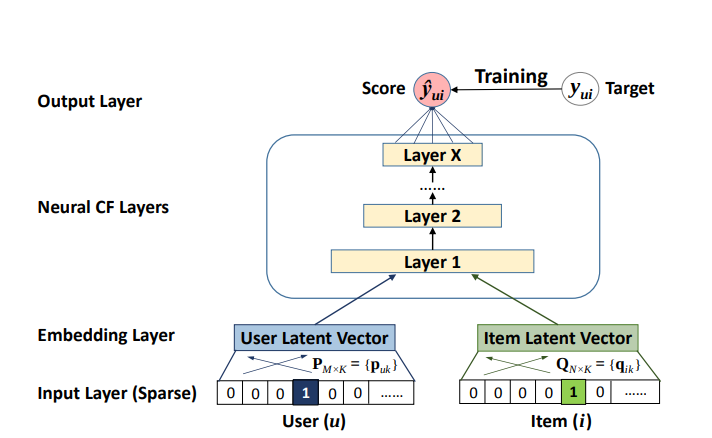

We use a simple architecture displayed above. For more details on embedding layers see upcoming lectures!

In [23]:
class NCF(nn.Module):
    def __init__(self, number_of_users, number_of_movies, embedding_size):
        super().__init__()
        self.embedding_layer_users = nn.Embedding(number_of_users, embedding_size)
        self.embedding_layer_movies = nn.Embedding(number_of_movies, embedding_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(in_features=2 * embedding_size, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1), # maybe predict per category?
            nn.ReLU()
        )

    def forward(self, users, movies):
        users_embedding = self.embedding_layer_users(users)
        movies_embedding = self.embedding_layer_movies(movies)
        concat = torch.cat([users_embedding, movies_embedding], dim=1)
        return torch.squeeze(self.feed_forward(concat))

In [24]:
# Parameters
batch_size = 1024
num_epochs = 25
show_validation_score_every_epochs = 1
embedding_size = 16
learning_rate = 1e-3

In [25]:
def mse_loss(predictions, target):
    return torch.mean((predictions - target) ** 2)

# Build Dataloaders
train_users_torch = torch.tensor(train_users, device=device)
train_movies_torch = torch.tensor(train_movies, device=device)
train_predictions_torch = torch.tensor(train_predictions, device=device)

train_dataloader = DataLoader(
    TensorDataset(train_users_torch, train_movies_torch, train_predictions_torch),
    batch_size=batch_size)

test_users_torch = torch.tensor(test_users, device=device)
test_movies_torch = torch.tensor(test_movies, device=device)

test_dataloader = DataLoader(
    TensorDataset(test_users_torch, test_movies_torch),
    batch_size=batch_size)

ncf = NCF(number_of_users, number_of_movies, embedding_size).to(device)

optimizer = optim.Adam(ncf.parameters(),
                       lr=learning_rate)

In [26]:
# collect losses for qualitative inspection
ncf_logdir = './tensorboard/ncf'
writer = SummaryWriter(ncf_logdir)

step = 0
with tqdm(total=len(train_dataloader) * num_epochs) as pbar:
    for epoch in range(num_epochs):
        for users_batch, movies_batch, target_predictions_batch in train_dataloader:
            optimizer.zero_grad()

            predictions_batch = ncf(users_batch, movies_batch)

            loss = mse_loss(predictions_batch, target_predictions_batch)

            loss.backward()

            optimizer.step()

            writer.add_scalar('loss', loss, step)
            pbar.update(1)
            step += 1

        if epoch % show_validation_score_every_epochs == 0:
            
            with torch.no_grad():
                all_predictions = []
                for users_batch, movies_batch in test_dataloader:
                    predictions_batch = ncf(users_batch, movies_batch)
                    all_predictions.append(predictions_batch)
                
            all_predictions = torch.cat(all_predictions)

            reconstuction_rmse = get_score(all_predictions.cpu().numpy())
            pbar.set_description('At epoch {:3d} loss is {:.4f}'.format(epoch, reconstuction_rmse))

            writer.add_scalar('reconstuction_rmse', reconstuction_rmse, step)

  0%|          | 0/25875 [00:00<?, ?it/s]

In [27]:
# We can visualize the tensorboard logs.
%load_ext tensorboard
%tensorboard --logdir ./tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

To consider:
* Try different layer choices.
* Can we also combine different aforementioned ideas in a neural network?

# Other ideas

Other ideas:
* Differentiable Inference and Generative Models.
* Adapt the loss for the predictions that are the most far off and contribute the most towards the RMSE.
* Graph-based approaches.
* Neighborhood approaches.
* Clustering approaches.
* Many more... Be creative!

----------

[1] Lee, Soojung. "Improving jaccard index for measuring similarity in collaborative filtering." International Conference on Information Science and Applications. Springer, Singapore, 2017.
[2] Liu, Haifeng, et al. "A new user similarity model to improve the accuracy of collaborative filtering." Knowledge-Based Systems 56 (2014): 156-166.



# Getting started with the project

### Google Colab:

Colaboratory, or "Colab" for short, allows you to write and execute Python in your browser, with 
- Zero configuration required
- Free access to GPUs
- Easy sharing

[Introduction to Colab](https://www.youtube.com/watch?v=inN8seMm7UI) to learn more.

### ETH clusters

ETH provides access to the [Euler](https://scicomp.ethz.ch/wiki/Euler) and [Leonhard](https://scicomp.ethz.ch/wiki/Leonhard) cluster (see also [Getting started with clusters](https://scicomp.ethz.ch/wiki/Getting_started_with_clusters#SSH_keys)).

To start:
- Open VPN!
- [Setup SSH keys](https://scicomp.ethz.ch/wiki/Getting_started_with_clusters#SSH_keys) (only need to do that once).
- Can even run jupyter-notebooks via [this](https://scicomp.ethz.ch/wiki/Jupyter_on_Euler_and_Leonhard_Open). If you want to run with a GPU may need to change the file accordingly (line 64: "python_cpu/3.6.4" -> "python_gpu/x.x.x" see [this](https://scicomp.ethz.ch/wiki/Python_on_Leonhard) for available versions, line 139 to request a GPU change rusage demands). To see tensorboard results you can mount the remote directory
```
sshfs <ethz-username>@<cluster-hostname>:<directory>
```
and run tensorboard locally 
```
tensorboard --logdir <directory>
```
